In [1]:
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import InputLayer
from keras.layers.convolutional import Conv3D
from keras.metrics import MeanAbsoluteError
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, InputLayer, TimeDistributed, Conv2D, Reshape
from keras import backend 



In [2]:
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
traning = r'D:\CS_Course_Material\Graduate_Program\workspace\DATA\2015-2020\firemask\train\fireMask\\'
validation = r'D:\CS_Course_Material\Graduate_Program\workspace\DATA\2015-2020\firemask\validate'
test = r'D:\CS_Course_Material\Graduate_Program\workspace\DATA\2015-2020\firemask\test\firemask'

In [4]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, preprocessing
import pandas as pd
import numpy as np
from scipy import ndimage
import os
from sklearn import preprocessing
from skimage import io
import cv2
import shutil
# from tweaked_ImageGenerator_v2 import ImageDataGenerator


from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import asarray
import math


In [5]:
batch_size = 2
train_samples = 34
val_samples = 8
img_width=img_height = 100 
 

# Functions

In [6]:

def resize(data,i_width,i_height,color_channels,flag='none',time_steps=1):
    thing = (len(data),time_steps,color_channels,i_height,i_width)
    thingy = np.zeros(thing)
    
    if(flag == 'stagger'):
        thingy = np.zeros((math.ceil((len(data)/time_steps)),time_steps,color_channels,i_height,i_width)) # (samples_in_totaL, steps per sample, total_color_chanles, width, height, )
        time = 0
        for x in data:
            photo = x
            thingy[(int)(time/time_steps)][time%time_steps] = photo
            time += 1
    if(flag == 'none'):
        for i in range(len(data)):
            if(i+8 < len(data)):
                photos = data[i:i+8]
                thingy[i][:] = photos
    return thingy

def checkDirectorySize(path_to_image_set_1,path_to_image_set_2):
        size1 = len([name for name in sorted(os.listdir(path_to_image_set_1))])
        size2 = len([name for name in sorted(os.listdir(path_to_image_set_2))])
        if(size1 >= size2): # if more images in first path
            return true
        return false
    
# Use this code to make new channels, run this once for each directory of image data we have

# shape = (<samples>,<x>,<y>,<color_chanel>)

# all_samples = np.empty(shape=(230,40,40,3), dtype = np.uint8)
def addImageSet(path_to_directory,num_of_imgs,color_channels_total,i_width,i_height,):
    photo = 0;
    color = 0;
    all_samples = np.empty(shape =(num_of_imgs,color_channels_total,i_height,i_width)) # total number of samples, color_chanels for this image set, img_height desired, img width desired
    for y in os.listdir(path_to_directory): # for all folders in directory of images
        path_to_current_directory = path_to_directory+"\\"+y
        photo_num = 0
        for x in sorted(os.listdir(path_to_current_directory)): # for all images in folder
            file = path_to_current_directory+"\\"+x
            if((file).endswith('.tif')):
                photo = io.imread(file) # read file and save
                photo = cv2.resize(photo,(i_width,i_height)) # resize photo to X x Y (40 x 40) 
                photo_res = np.reshape(photo, (1,i_height,i_width)) # extend to have color_channel number added 
                all_samples[photo_num][color] = photo_res # add sample to color channel 
                photo_num += 1 # move to next photo
        color = color +1 # move to next set of images
    return all_samples

def printImagesInSequence(data,time_step,sample,chanel):
    rows = math.floor(time_step/4)
    fig = plt.figure()
    fig.set_figheight(9*(time_step/4))
    fig.set_figwidth(15*(time_step/4))
    gs = fig.add_gridspec(rows,4)
    ax = gs.subplots(sharex=True, sharey=True)
    day =0;
    for i in range(rows):
        if(rows == 1):
            for y in range(4):
                ax[y].imshow(data[sample][y][chanel])
                day += 1
                ax[y].set_title("Sample "+str(sample)+"Day "+ str(day))
        else :
             for y in range(4):
                ax[i,y].imshow(data[sample][i*y][chanel])
                day += 1
                ax[i,y].set_title("Sample "+str(sample)+"Day "+ str(day))

In [7]:
path_to_all_data_X = r'D:\CS_Course_Material\Graduate_Program\workspace\DATA\current_data\new_data\X\EPSG_4326\\'
path_to_all_data_y = r'D:\CS_Course_Material\Graduate_Program\workspace\DATA\current_data\new_data\y\EPSG_4326\\'
X_full = addImageSet(path_to_all_data_X,2525,4,img_height,img_width)
y_full = addImageSet(path_to_all_data_y,2525,1,img_height,img_width)


In [8]:
print(X_full.shape,y_full.shape)

(2525, 4, 100, 100) (2525, 1, 100, 100)


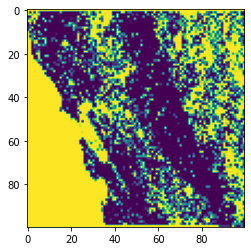

In [9]:
img_test = X_full[0][0]
imgplt = plt.imshow(img_test)

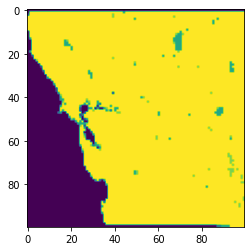

In [10]:
img_test = y_full[0][0]
imgplt = plt.imshow(img_test)

In [11]:
X = resize(X_full,img_width,img_height,4,'none',8)
y = resize(y_full,img_width,img_height,1,'none',8)

print(X.shape,y.shape)


(2525, 8, 4, 100, 100) (2525, 8, 1, 100, 100)


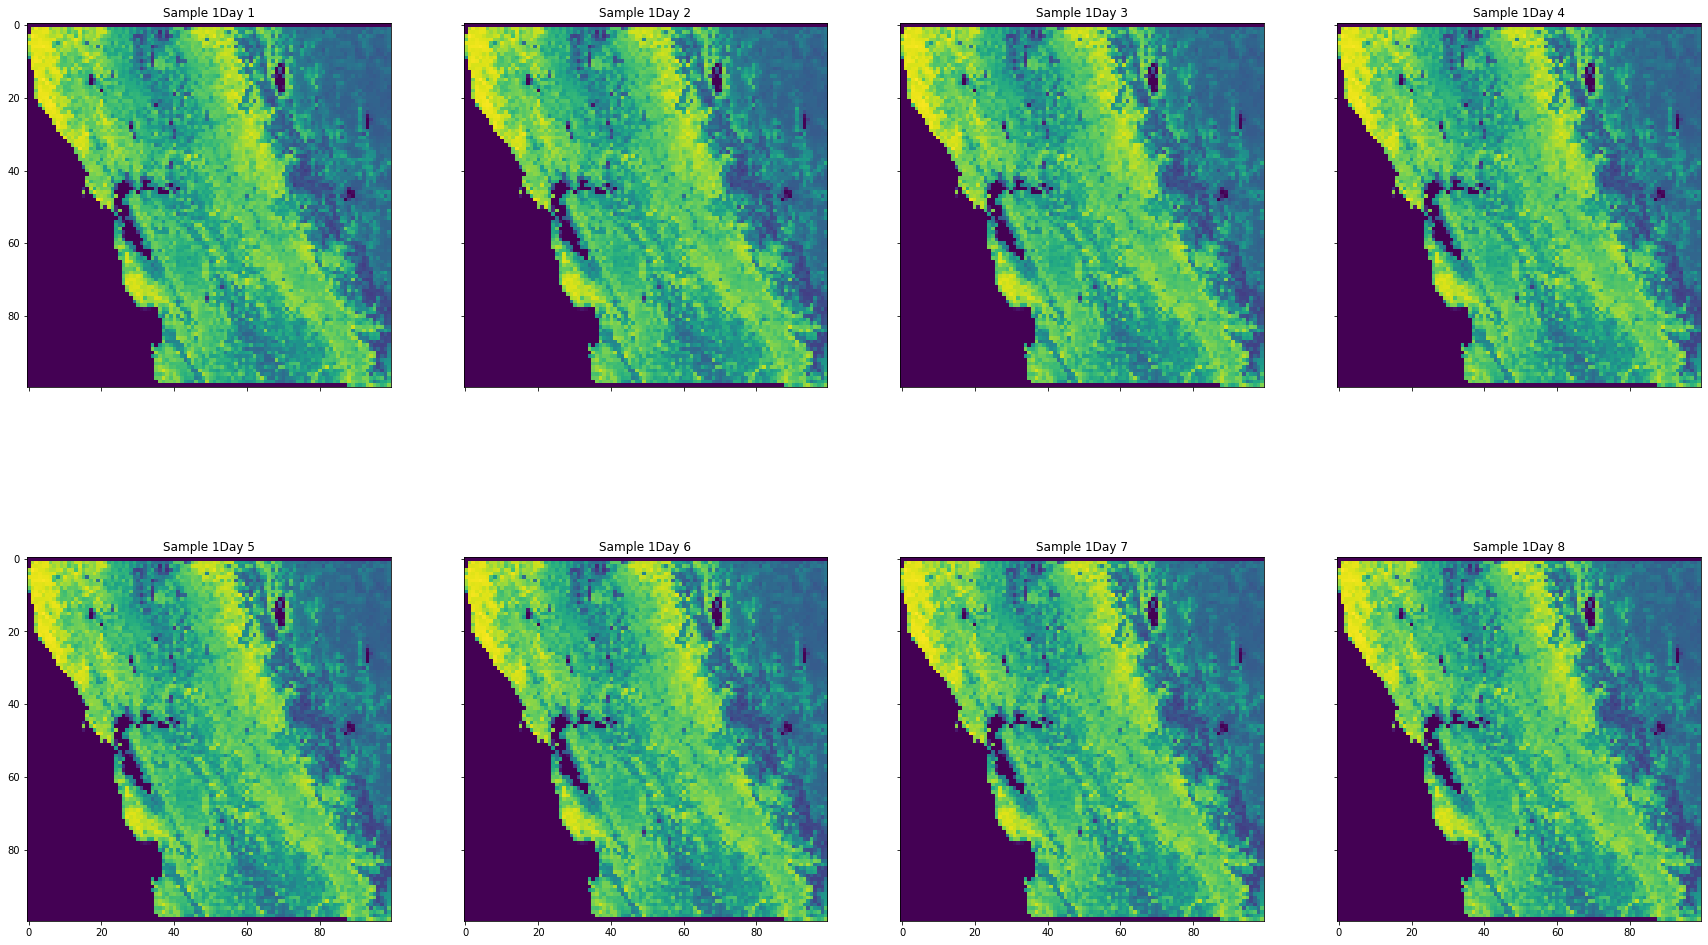

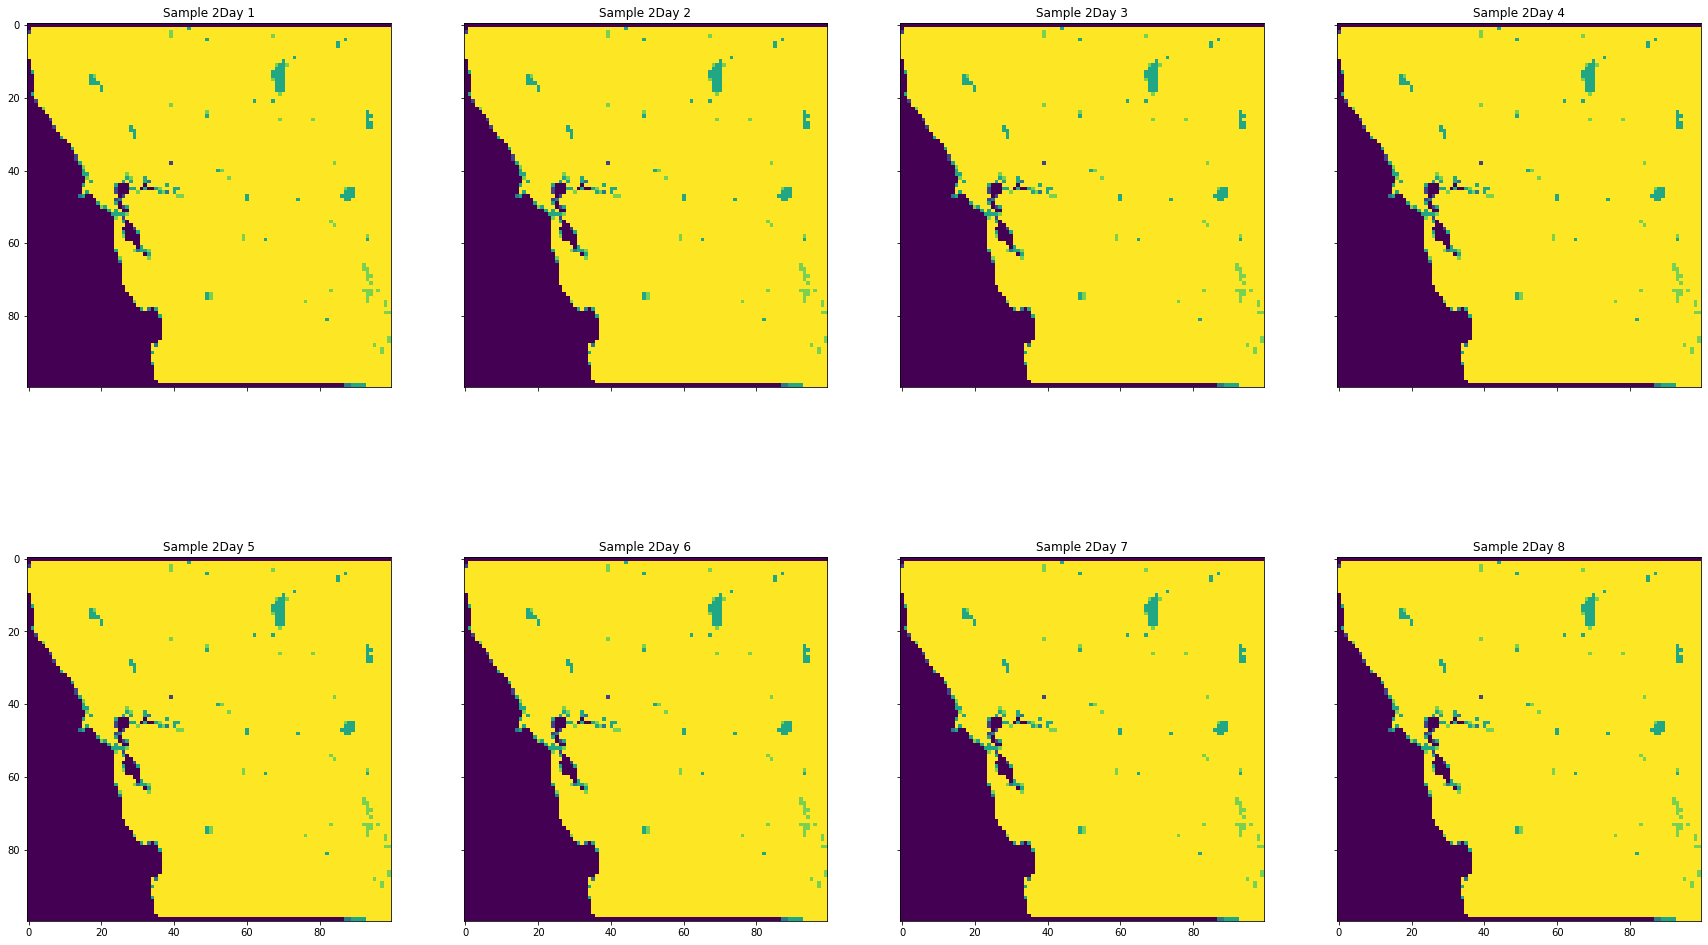

In [12]:
printImagesInSequence(X,8,1,1)
printImagesInSequence(y,8,2,0)

In [13]:
#next fram prediction
# we want to now stagger the dataset, we can remove the first instance of y,  
y_staggered = y[1:]
X_staggered = X[:(len(X)-1)]
print(y_staggered.shape,X_staggered.shape)

(2524, 8, 1, 100, 100) (2524, 8, 4, 100, 100)


In [14]:
indexes_x = np.arange(X_staggered.shape[0])
indexes_y = np.arange(y_staggered.shape[0])
np.random.shuffle(indexes_x)
np.random.shuffle(indexes_y)

train_index_x = indexes_x[: int(0.9 * X_staggered.shape[0])]
val_index_x = indexes_x[int(0.9 * X_staggered.shape[0]) :]
train_index_y = indexes_y[: int(0.9 * y_staggered.shape[0])]
val_index_y = indexes_y[int(0.9 * y_staggered.shape[0]) :]

train_dataset_x = X_staggered[train_index_x]
val_dataset_x = X_staggered[val_index_x]

train_dataset_y = y_staggered[train_index_y]
val_dataset_y = y_staggered[val_index_y]


# Normalize the data to the 0-1 range.
train_dataset_x = train_dataset_x / 255
val_dataset_x = val_dataset_x / 255

train_dataset_y = train_dataset_y / 255
val_dataset_y = val_dataset_y / 255


In [15]:
print(train_dataset_x.shape,val_dataset_x.shape)
print(train_dataset_y.shape,val_dataset_y.shape)

(2271, 8, 4, 100, 100) (253, 8, 4, 100, 100)
(2271, 8, 1, 100, 100) (253, 8, 1, 100, 100)


In [19]:


# samples = 318
# time = 6
# channels = 2
# rows = 100
# column = 267


backend.clear_session()
seq = Sequential()
seq.add(InputLayer(input_shape=(8,4,100,100)))
seq.add(ConvLSTM2D(filters=4,
                   kernel_size=(1, 1),
                   padding='same', 
                   return_sequences=True,
                   data_format='channels_first',
                  activation='sigmoid'))
seq.add(MaxPooling3D())
seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid', 
               padding='same', data_format='channels_first'))
# seq.add(Flatten())


seq.compile(loss='mae', optimizer='adadelta', metrics =['mae'])
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 8, 4, 100, 100)    144       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 2, 50, 100)    0         
 )                                                               
                                                                 
 conv3d (Conv3D)             (None, 1, 2, 50, 100)     109       
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


In [21]:
seq.fit(train_dataset_x,train_dataset_y,epochs=10, batch_size = 1, validation_data=(val_dataset_x,val_dataset_y))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [76]:
example = val_dataset_x[np.random.choice(range(len(val_dataset_x)), size=1)[0]]

In [77]:
print(example.shape)

(8, 4, 100, 100)


In [75]:
frames = example[:8,...]
print(frames.shape)
original_frames = example[8:,...]
print(original_frames.shape)

(8, 4, 100, 100)
(0, 4, 100, 100)


In [78]:
new_prediction = seq.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)



1/1 [==============================] - 0s 21ms/step


In [79]:
predicted_frame.shape

(1, 4, 100, 100)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# # Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + 11}")
#     ax.axis("off")

# Plot the new frames.
# new_frames = frames[10:, ...]
# for idx, ax in enumerate(axes[1]):
#     ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + 11}")
#     ax.axis("off")

# Display the figure.
for i in range(4):
    print
plt.show()

In [ ]:
print(pred.shape)

In [ ]:
pred=np.squeeze(pred,axis=1)

In [ ]:
print(pred.shape)

In [ ]:
plt.imshow(pred[200][0])

In [ ]:

predicted_frame = np.expand_dims(pred[-1,...],axis=0)

plt.imshow(predicted_frame)

# print(pred)
# print(pred.shape)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize = (100,100))
for i in range(0,10):
    array = np.reshape(pred[i], (100,100))
#     print(i, array)
    ax[i].imshow(array, cmap ='gray')



# Old Code

In [ ]:
# import GenData as gd
# from GenData import ImageDataGenerator, DirectoryIterator

# train_datagen = ImageDataGenerator(rescale=1. /255)
# validate_datagen = ImageDataGenerator(rescale=1. /255)
# test_datagen  = ImageDataGenerator()


# Custom parameters
# params = {'dim':(img_width,img_height),
#          'batch_size': batch_size,
#          'n_classes':2,
#          'n_channels':1,
#           'time': 1
#          }
# train_generator =()

#     def change_dims(self, x):
#     	"""expands dimenstions of a batch of images"""
#     	img_channel_axis = self.channel_axis #- 1
#     	x = np.expand_dims(x, axis=0)
#     	return x

# train_data =  tf.keras.utils.image_dataset_from_directory(
#     traning,
#     color_mode = 'grayscale',
#     batch_size=1,
#     image_size=(img_width, img_height)
# #     validation_split=.1,
# )

# train_generator = train_datagen.flow_from_directory(
#     traning,
#     target_size=(img_width, img_height),
#     color_mode = 'grayscale',
#     batch_size=1,
#     class_mode ='categorical'
# )

# validate_generator = validate_datagen.flow_from_directory(
#     validation,
# #     frames_per_step =1,
#     color_mode ='grayscale',
#     target_size=(img_width, img_height),
#     batch_size=1,
#     class_mode ='categorical'
# )


# train_generator = change_dims(train_generator, 5)

# print(type(train_generator))

# this is for the generator and adding the 5th dimession necesary for the data set

